In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
import string
from collections import Counter
from sklearn.decomposition import NMF

In [2]:
with open('data/script_df.pkl', 'rb') as f:
    movie_df = pickle.load(f)

In [3]:
with open('data/nnp.pkl', 'rb') as f:
    nnp = pickle.load(f)

In [4]:
stop_word = stopwords.words('english')
stop_word.extend(['dr', 'de', 'san','looks', 'uh', 'huh', 'miss', 'mr', 'guys', 'gov', 'ya', 'sir', 'sr', 'st', "cont'd",
    'cannot', "wouldn't", "i'm", "ain't", "can't", "they've", 'gotta', 'gonna', 'outta', 'new',  'really', 'ok', 'yeah', 'phone',  'towards', 'pat', 'em',  'x', 'yes', 'no', 'hey', 'ah', 'ahh',
    'somethin', "nothin", 'something', 'nothing', 'wanna', 'gonna', 'goin', 'away',
    'ow', 'um', 'hmm', 'ha', 'ho', 'whoa', 'um', 'wow', 'aah', 'hee', 'hah', 
    'revision', 'back', 'voice'])
stop_word = set(stop_word).union(nnp)

Transform the text into vectors using TFIDFVectorizer

In [5]:
tfidf = TfidfVectorizer(stop_words = stop_word, min_df=20, max_df=0.70)
tfidf_vec = tfidf.fit_transform(movie_df['scripts'])

In [6]:
word_list = np.array(tfidf.get_feature_names())
len(word_list)

12394

In [7]:
n_components = 32
nmf = NMF(n_components=n_components, tol=0.00001, random_state=42)
nmf_topic_vec = nmf.fit_transform(tfidf_vec)

In [8]:
nmf_word_vec = nmf.components_
nmf_word_top10 = np.argsort(nmf_word_vec, axis = 1)[:, -1:-15:-1]

In [9]:
for i in range (len(nmf_word_top10)):
    key_word = ', '.join(word_list[nmf_word_top10[i]])
    print(i, key_word)

0 apartment, elevator, bedroom, bathroom, telephone, hotel, cab, closet, cigarette, suitcase, sidewalk, piano, taxi, coat
1 computer, monitor, elevator, agent, screen, security, disk, guard, helicopter, video, van, weapon, lab, code
2 carriage, dear, london, letter, tea, sister, servant, daughter, perhaps, garden, rather, gentleman, england, husband
3 ship, planet, crew, console, deck, shuttle, robot, bridge, probe, airlock, earth, panel, warp, pod
4 wedding, sex, date, totally, couch, fun, married, gay, weird, cool, sister, wine, bathroom, photo
5 fucking, fuckin, mate, motherfucker, drug, bitch, cigarette, beer, coke, bullshit, asshole, cunt, dollar, pussy
6 sword, castle, battle, arrow, guard, horse, warrior, knight, samurai, forest, throne, armor, pirate, creature
7 soldier, rifle, trench, army, german, bullet, bomb, officer, grenade, colonel, bunker, military, weapon, convoy
8 boat, deck, shark, island, dock, sea, beach, raft, ocean, crew, cabin, sail, shore, fin
9 vampire, stake,

In [10]:
#save result
result = (nmf_topic_vec, nmf, nmf_word_vec, tfidf)
with open('result/nmf_model.pkl', 'wb') as f:
    pickle.dump(result, f)

### EDA on the topic result
Check the distribution of the most important topic for each movie

In [11]:
movie_topic = nmf_topic_vec.argmax(axis=1)
df_res=pd.Series(movie_topic).value_counts()

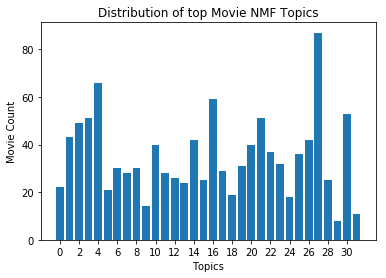

In [12]:
plt.bar(range(len(df_res)),df_res.sort_index())
plt.ylabel('Movie Count')
plt.xticks(range(0,len(df_res),2), range(0,len(df_res),2) )
plt.xlabel('Topics')
plt.title('Distribution of top Movie NMF Topics');

### Visualization of topics using t-sne

In [13]:
from sklearn.manifold import TSNE

In [14]:
tsne = TSNE(random_state=42, learning_rate=350)
tsne_res = tsne.fit_transform(nmf_topic_vec)

In [15]:
tsne_df = pd.DataFrame(np.concatenate([tsne_res, np.argmax(nmf_topic_vec, axis=1).reshape(len(movie_df), 1)], axis=1),
                      columns=['d1', 'd2', 'topic'])
tsne_df['title'] = movie_df['title']

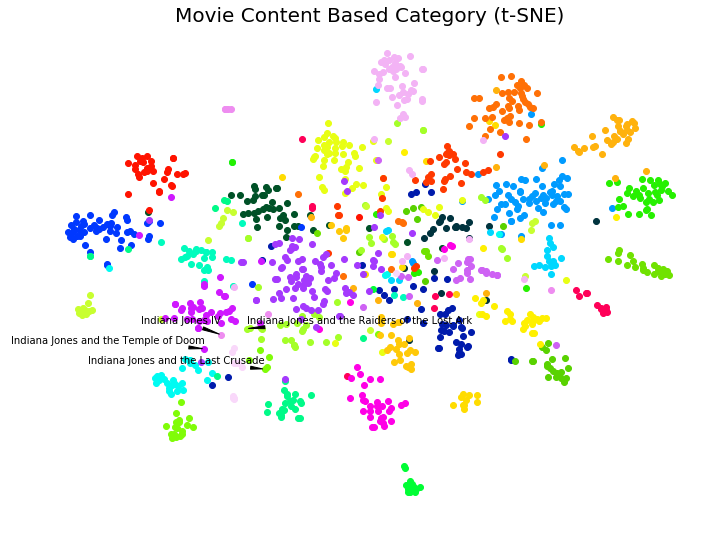

In [16]:
fig, ax = plt.subplots(1,1, figsize=(12,9))
for c, group in tsne_df.groupby('topic'):
    ax.scatter(group['d1'], group['d2'], color=plt.cm.gist_ncar((float(c)+1) / (n_components+1)), label=str(int(c)))
ax.axis('off')
ax.annotate(tsne_df.loc[534,'title'], xy=(tsne_df.loc[534,'d1'], tsne_df.loc[534,'d2']),
            xytext=(tsne_df.loc[534,'d1'], tsne_df.loc[534,'d2']+1),
            arrowprops=dict(facecolor='black', arrowstyle="wedge"),
            horizontalalignment='right')
ax.annotate(tsne_df.loc[535,'title'], xy=(tsne_df.loc[535,'d1'], tsne_df.loc[535,'d2']),
            xytext=(tsne_df.loc[535,'d1'], tsne_df.loc[535,'d2']+1),
            arrowprops=dict(facecolor='black', arrowstyle="wedge"),
            horizontalalignment='left')
ax.annotate(tsne_df.loc[536,'title'], xy=(tsne_df.loc[536,'d1'], tsne_df.loc[536,'d2']),
            xytext=(tsne_df.loc[536,'d1'], tsne_df.loc[536,'d2']+1),
            arrowprops=dict(facecolor='black', arrowstyle="wedge"),
            horizontalalignment='right')
ax.annotate(tsne_df.loc[537,'title'], xy=(tsne_df.loc[537,'d1'], tsne_df.loc[537,'d2']),
            xytext=(tsne_df.loc[537,'d1'], tsne_df.loc[537,'d2']+2),
            arrowprops=dict(facecolor='black', arrowstyle="wedge"),
            horizontalalignment='right')
ax.set_title('Movie Content Based Category (t-SNE)', fontsize=20);

Some movies have similar elements in the content, but the genres are different. Like the animation movie Finding Nemo and the movie Jaws (both are adventures in the ocean and contains the plot of trying to escape from Shark attack...)It is important to take genre into consideration when make recommendation. 

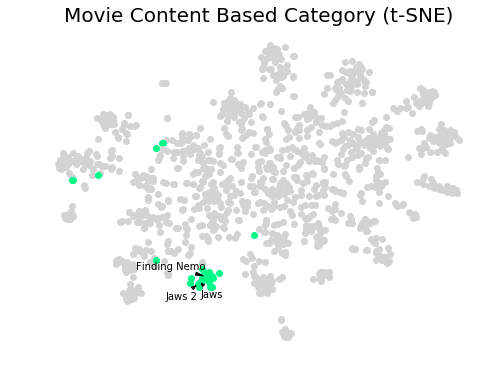

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
for c, group in tsne_df.groupby('topic'):
    if c == 8:
        ax.scatter(group['d1'], group['d2'], 
                   color=plt.cm.gist_ncar((float(c)+1) / (n_components+1)), 
                   label=str(int(c)))
    else:
        ax.scatter(group['d1'], group['d2'], 
                   color='lightgrey', 
                   label=str(int(c)))            
ax.axis('off')

ax.annotate(tsne_df.loc[381,'title'], xy=(tsne_df.loc[381,'d1'], tsne_df.loc[381,'d2']),
            xytext=(tsne_df.loc[381,'d1'], tsne_df.loc[381,'d2']+2),
            arrowprops=dict(facecolor='black', arrowstyle="wedge"),
            horizontalalignment='right')
ax.annotate(tsne_df.loc[563,'title'], xy=(tsne_df.loc[563,'d1'], tsne_df.loc[563,'d2']),
            xytext=(tsne_df.loc[563,'d1'], tsne_df.loc[563,'d2']-2),
            arrowprops=dict(facecolor='black', arrowstyle="wedge"),
            horizontalalignment='left', verticalalignment='top')
ax.annotate(tsne_df.loc[564,'title'], xy=(tsne_df.loc[564,'d1'], tsne_df.loc[564,'d2']),
            xytext=(tsne_df.loc[564,'d1'], tsne_df.loc[564,'d2']-2),
            arrowprops=dict(facecolor='black', arrowstyle="wedge"),
            horizontalalignment='right', verticalalignment='top')

ax.set_title('Movie Content Based Category (t-SNE)', fontsize=20);

In [18]:
tsne_df.to_csv('result/tsne.csv', sep=',')